In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import osmnx as ox
from datetime import datetime
from scipy import spatial, stats
import shapely
import matplotlib.dates as mdates
import numpy as np

In [2]:
oyster = pd.read_csv('/Users/itto/Downloads/Nov09JnyExport.csv')
# Clean up the data
oyster_data = oyster.loc[oyster.StartStn != 'Bus'].loc[oyster.StartStn != 'Unstarted'].loc[oyster.EndStation != 'Bus']
oyster_data.EntTimeHHMM = oyster_data.EntTimeHHMM.str.replace('24:','00:')
oyster_data.EntTimeHHMM = oyster_data.EntTimeHHMM.str.replace('25:','01:')

In [3]:
counts_en = pd.read_csv('/Users/itto/Downloads/counts/En17week.csv', skiprows=6).set_index(' Station')
counts_ex = pd.read_csv('/Users/itto/Downloads/counts/Ex17week.csv', skiprows=6).set_index(' Station')

# We only care about the time columns
time_columns = counts_en.columns[4:-8]

# Easier to work with stations as columns, so transpose
data_en = counts_en.loc[:, time_columns].T
data_ex = counts_ex.loc[:, time_columns].T

# Remove "Total" column
data_en.drop('Total',axis=1,inplace=True)
data_ex.drop('Total',axis=1,inplace=True)

# Extract the first time
data_en.index = data_en.index.str[:4]
data_ex.index = data_en.index.str[:4]

# Convert to datetime format
data_en.index = pd.to_datetime(data_en.index, format='%H%M')
data_ex.index = pd.to_datetime(data_en.index, format='%H%M')

Let's start by just getting a sense of the data. First, we plot the entrances into some stations.

In [4]:
MONTAGE_SIZE = 5

In [5]:
data_plot_en = data_en.sample(MONTAGE_SIZE**2, random_state=23, axis=1)
data_plot_ex = data_ex.sample(MONTAGE_SIZE**2, random_state=23, axis=1)

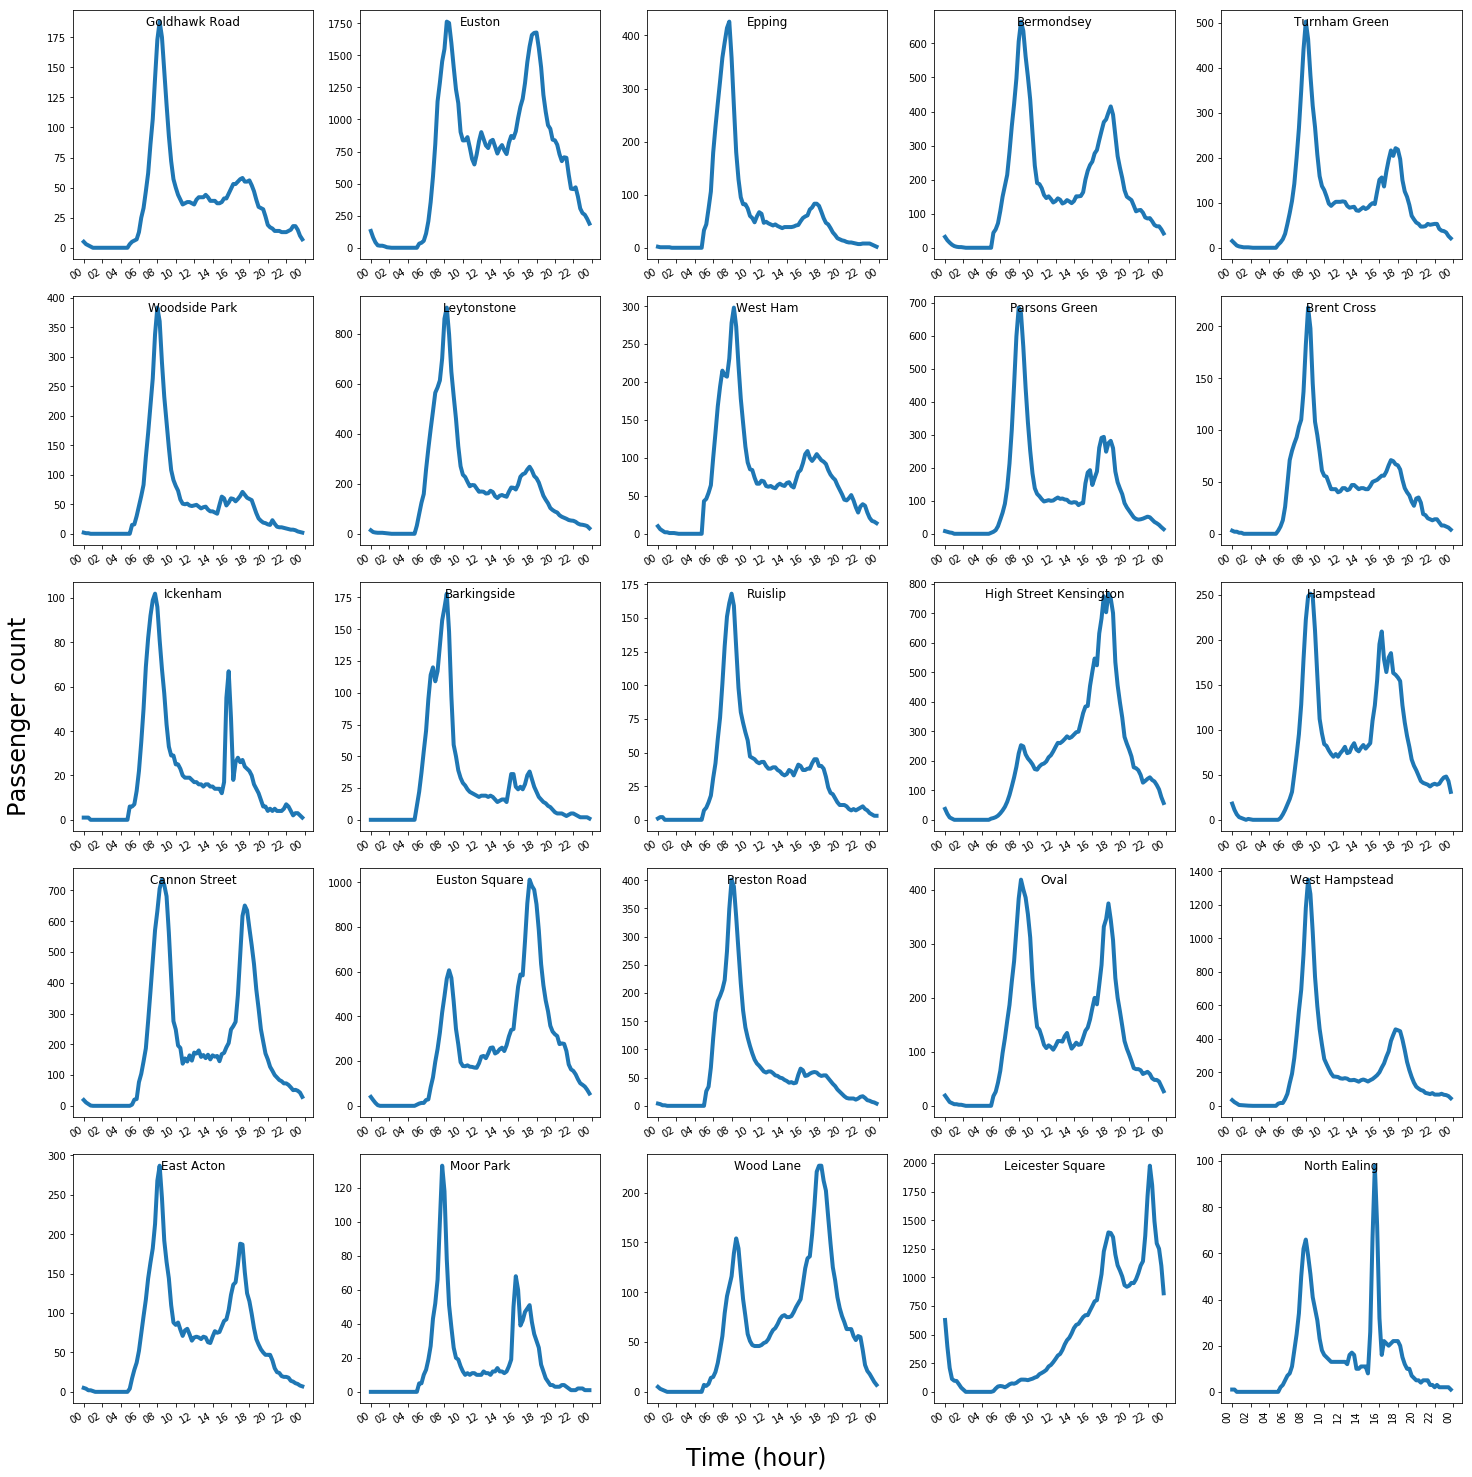

In [6]:
f, axes = plt.subplots(MONTAGE_SIZE,MONTAGE_SIZE,figsize=(20,20), sharey=False, sharex=False)
for i in range(MONTAGE_SIZE**2):
    ax = axes.flatten()[i]
    data_plot_en.iloc[:,i].plot(color='C0', ax=ax, lw=4)
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax.set_title(data_plot_en.columns[i],pad=-15)
    ax.set_xlabel('')
plt.xticks(rotation=90)
f.text(0.5, -0.02, 'Time (hour)', ha='center', size=24)
f.text(-0.02, 0.5, 'Passenger count', va='center', rotation='vertical', size=24)
plt.tight_layout()

Already we can see morning and afternoon rushes. We can also see assymetries. But each subplot here is has it's own scale. For an objective view, we need to compare subplots along the same scale. 

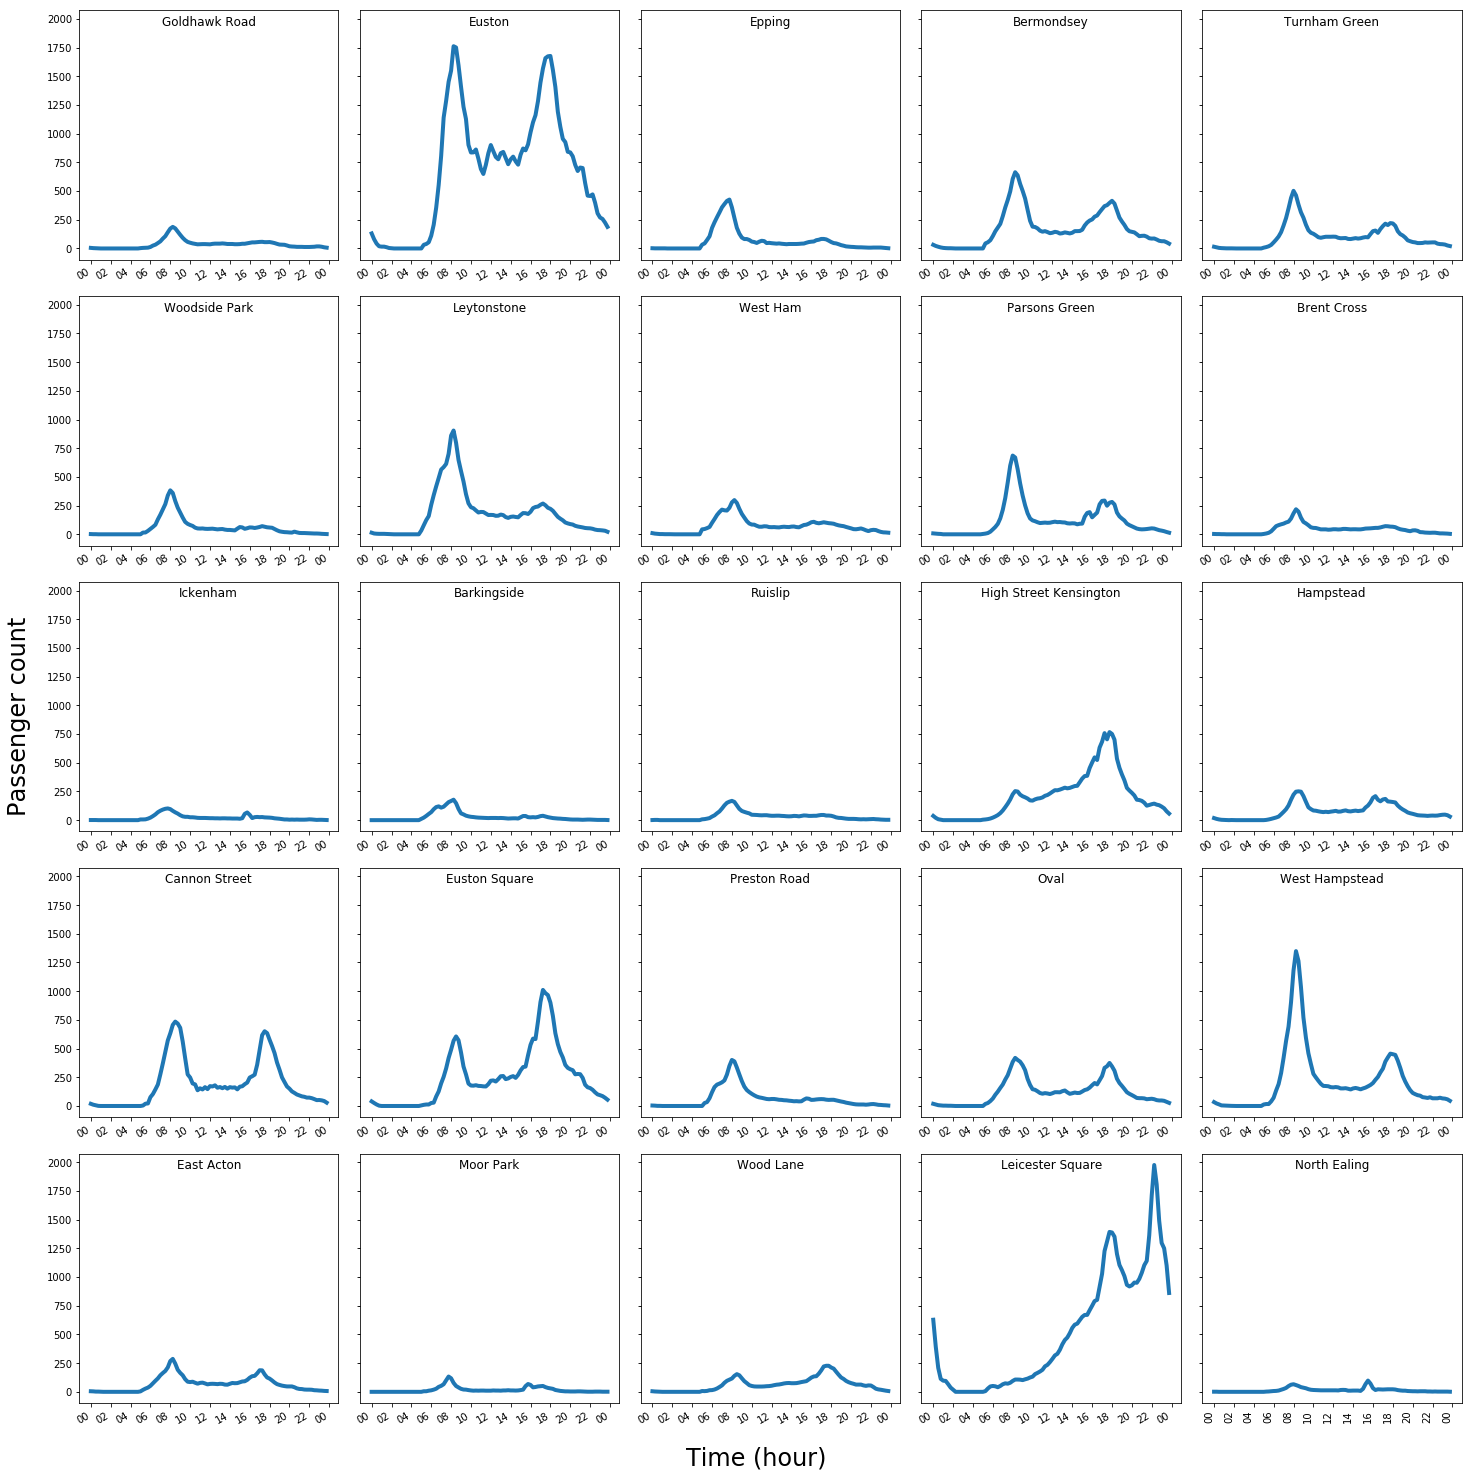

In [7]:
f, axes = plt.subplots(MONTAGE_SIZE,MONTAGE_SIZE,figsize=(20,20), sharey=True, sharex=False)
for i in range(MONTAGE_SIZE**2):
    ax = axes.flatten()[i]
    data_plot_en.iloc[:,i].plot(color='C0', ax=ax, lw=4)
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax.set_title(data_plot_en.columns[i],pad=-15)
plt.xticks(rotation=90)
f.text(0.5, -0.02, 'Time (hour)', ha='center', size=24)
f.text(-0.02, 0.5, 'Passenger count', va='center', rotation='vertical', size=24)
plt.tight_layout()

We can still discern rush hour patterns. But now we can see that some stations are clearly more active than others. Now let's look at the exits as well. Let's overlay the two on top of each other.

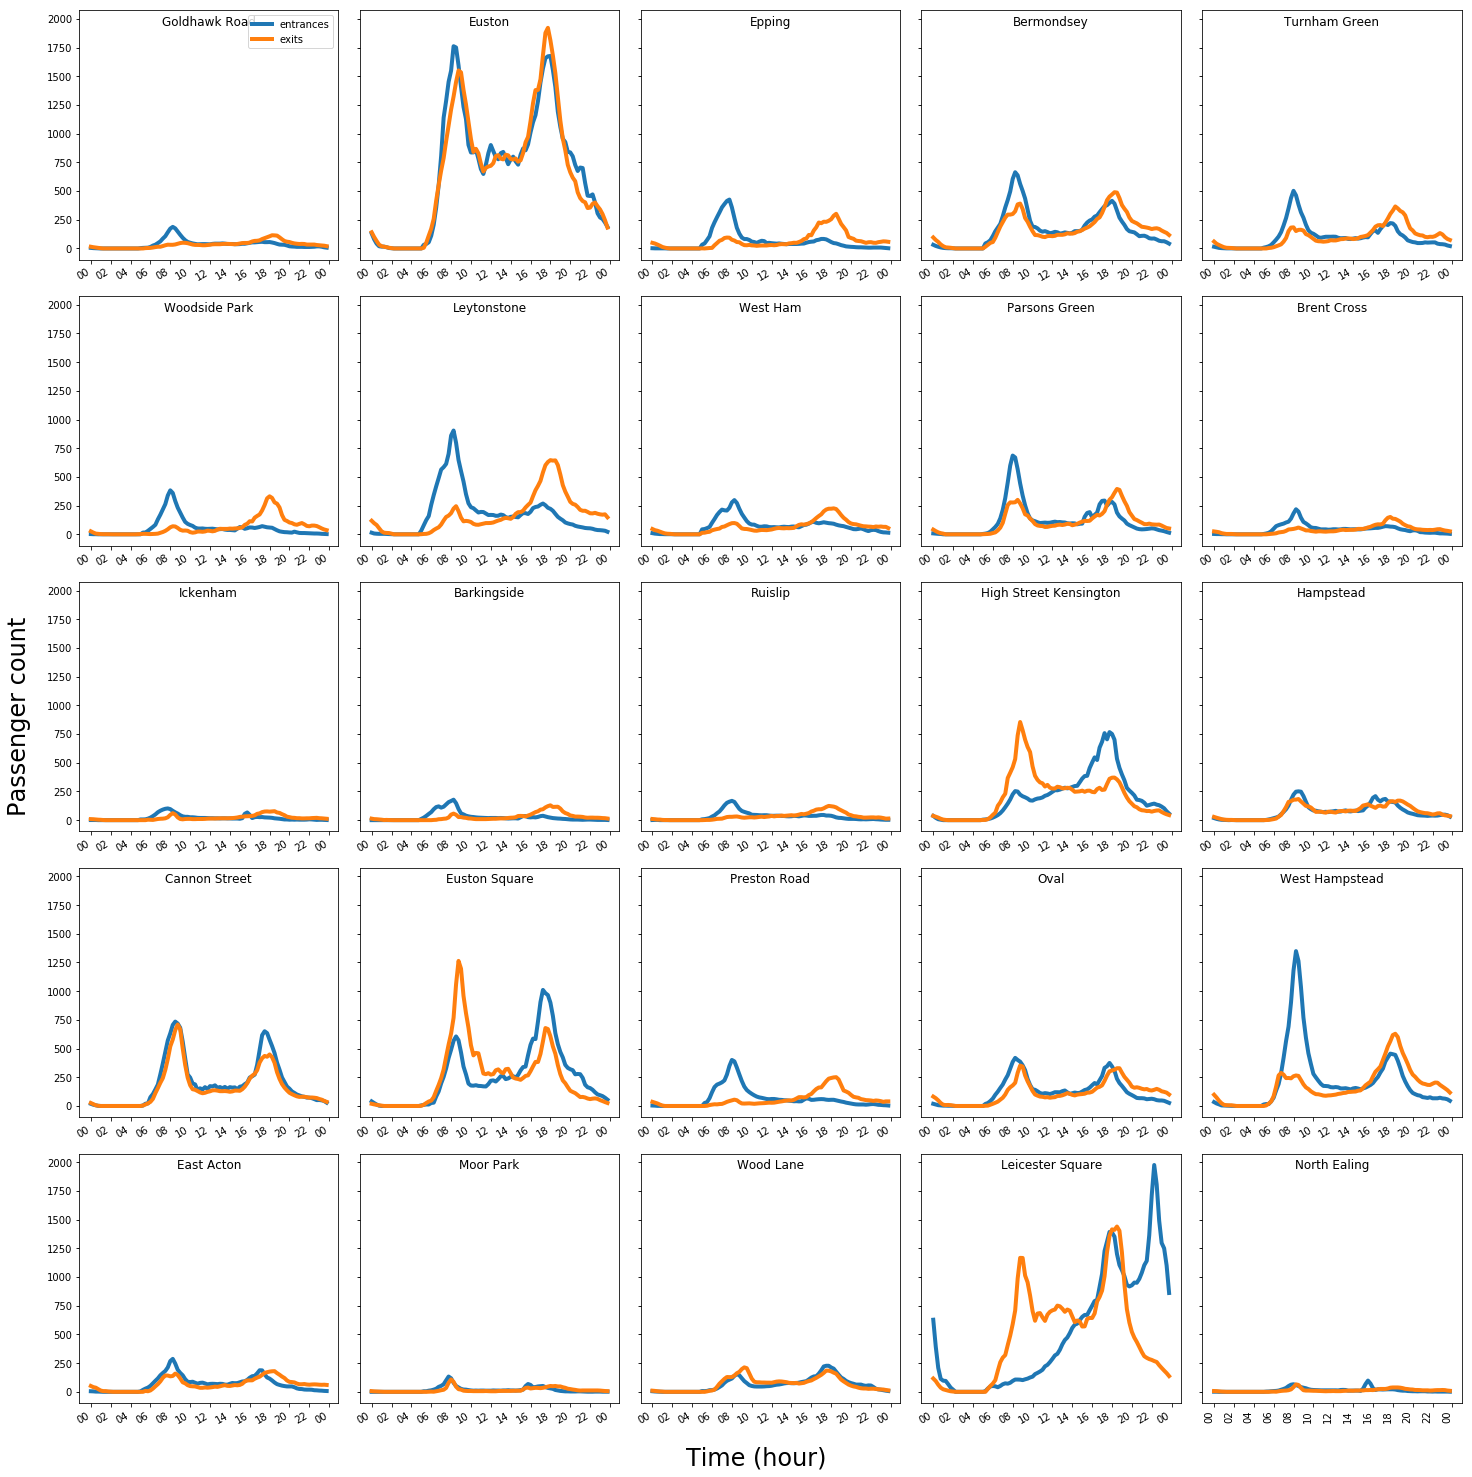

In [8]:
f, axes = plt.subplots(MONTAGE_SIZE,MONTAGE_SIZE,figsize=(20,20), sharey=True, sharex=False)
for i in range(MONTAGE_SIZE**2):
    ax = axes.flatten()[i]
    data_plot_en.iloc[:,i].plot(color='C0', ax=ax, lw=4, label='entrances')
    data_plot_ex.iloc[:,i].plot(color='C1', ax=ax, lw=4, label='exits')
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    # First plot should have a legend
    if not i:
        ax.legend(loc = 'upper right')
    ax.set_title(data_plot_en.columns[i],pad=-15,loc='center')
plt.xticks(rotation=90)
f.text(0.5, -0.02, 'Time (hour)', ha='center', size=24)
f.text(-0.02, 0.5, 'Passenger count', va='center', rotation='vertical', size=24)
plt.tight_layout()

Some stations have a balance in entrances and exits throughout the day. But in many stations we can see asymmetry between entrances and exits: where there is a peak in one there isn't in the other. It also seems like the more active stations have exit peaks in the daytime and entrance peaks in the afternoon, which would hint at these being stations where people arrive at work.

The above quick analysis hints at two phenomena:
1. Stations exhibit morning and afternoon peaks
1. Entrances and exits are often imbalanced throughout the day. Some stations are biased towards morning entrances, wheras others are biased towards morning exits.

Let's take these qualitative findings and try to describe them more quantitatively. For this, we need to start looking at the system as a whole. First, we aggregate all entrances and all exits, and plot them as a time series.

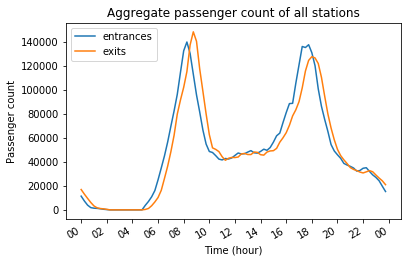

In [9]:
ax = data_en.sum(axis=1).plot(label = 'entrances');
data_ex.sum(axis=1).plot(ax=ax, label='exits');
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax.set_xlabel('Time (hour)')
ax.set_ylabel('Passenger count')
ax.set_title('Aggregate passenger count of all stations')
ax.legend()
plt.show()

We immediately notice a few things:
1. The entrance and exit patterns are extremely similar. This tells us is that the system is that there is no aggregation of passengers in the stations: those that check in to the system also check out. This is a nice sanity check on our data, but not much else.
1. The system as a whole experience what we will now term a *commuting pattern*. That is, peak activity in the morning and in the late afternoon.
1. The entrances in the morning are roughly the same as those in the afternoon. If we assume that the same people who take the train in the day also take it in the afternoon, this suggests that the net flow of people is zero.
1. Like entrances, the AM and PM peaks of the exits are quite similar, but there is a slight difference. Why is this? Are less people taking the train home than they did to get to work? This might indicate some vulnerability in the data, and might be worth investigating.
1. The exits are temporally delayed relative to the entrances. This could provide an interesting indication of the overall delay in the transit system, but it's beyond our scope for the time being.

When we looked at a handful of stations previously, we saw that some are biased towards morning entrances, while others towards morning exits. We can describe this for the entire system by looking at the ratio of entrances/exits

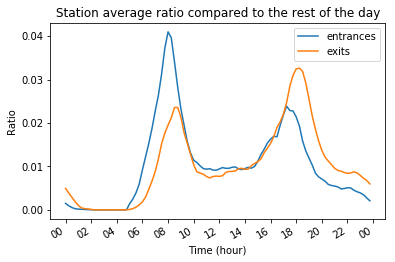

In [10]:
ax = (data_en/data_en.sum(axis=0)).mean(axis=1).plot(label='entrances');
(data_ex/data_ex.sum(axis=0)).mean(axis=1).plot(ax=ax, label='exits');
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax.set_xlabel('Time (hour)')
ax.set_ylabel('Ratio')
ax.set_title('Station average ratio compared to the rest of the day')
ax.legend()
plt.show()

We see a difference compared to the aggregated passenger counts. Before, the morning and afternoon patterns were about equal. Moreover, the entrance and exit time distribution was similar (with a slight temporal shift). But now, when we look at the average ratio, we see a significant decrease in entrances in the afternoon, and in exits in the morning. This tells us that, while the entire system is balanced in passenger counts, there are actually more residential stations (exhibiting morning entrances and afternoon exits) than there are work stations. This means that we have a few high activity stations which exhibit a work-hub pattern. 


So we can already see a well-defined phenomenon of morning and afternoon peaks, and the binary behaviour of either being a residental or a CBD type station. Let's delve into this. We begin by looking at the distribution of stations' morning and afternoon ridership ratios. 

In [11]:
time_of_day = {
    6: 'rush_am',
    7: 'rush_am',
    8: 'rush_am',
    9: 'rush_am',
    16: 'rush_pm',
    17: 'rush_pm',
    18: 'rush_pm',
    19: 'rush_pm'
}

In [12]:
ratios = data_en/data_en.sum(axis=0)
# Define rush hour times
ratios['rush'] = ratios.index.hour.map(time_of_day)
# Sum all the rush hour times into one ratio per station
ratio_rush_en = ratios.loc[ratios.rush == 'rush_am',ratios.columns != 'rush'].sum(axis=0)
ratios = data_ex/data_ex.sum(axis=0)
ratios['rush'] = ratios.index.hour.map(time_of_day)
ratio_rush_ex = ratios.loc[ratios.rush == 'rush_am',ratios.columns != 'rush'].sum(axis=0)

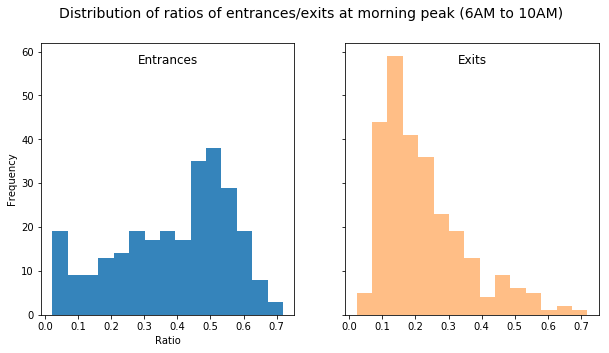

In [13]:
f, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
n,bins,patches = ax[0].hist(ratio_rush_en,bins=15,alpha=0.9);
ax[0].set_title('Entrances', y=0.90)
ax[0].set_xlabel('Ratio')
ax[0].set_ylabel('Frequency')
ax[1].hist(ratio_rush_ex, bins=bins,alpha=0.5, color='C1');
ax[1].set_title('Exits', y=0.90)
f.suptitle('Distribution of ratios of entrances/exits at morning peak (6AM to 10AM)', size=14);

In [14]:
ratios = data_en/data_en.sum(axis=0)
# Define rush hour times
ratios['rush'] = ratios.index.hour.map(time_of_day)
# Sum all the rush hour times into one ratio per station
ratio_rush_en = ratios.loc[ratios.rush == 'rush_pm',ratios.columns != 'rush'].sum(axis=0)
ratios = data_ex/data_ex.sum(axis=0)
ratios['rush'] = ratios.index.hour.map(time_of_day)
ratio_rush_ex = ratios.loc[ratios.rush == 'rush_pm',ratios.columns != 'rush'].sum(axis=0)

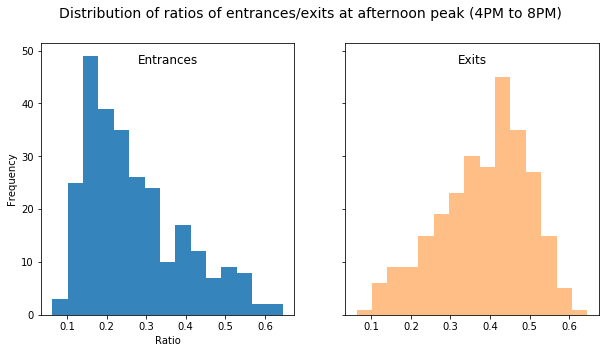

In [15]:
f, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
n,bins,patches = ax[0].hist(ratio_rush_en,bins=15,alpha=0.9);
ax[0].set_title('Entrances', y=0.90)
ax[0].set_xlabel('Ratio')
ax[0].set_ylabel('Frequency')
ax[1].hist(ratio_rush_ex, bins=bins,alpha=0.5, color='C1');
ax[1].set_title('Exits', y=0.90)
f.suptitle('Distribution of ratios of entrances/exits at afternoon peak (4PM to 8PM)', size=14);

What we see is that most stations exhibit a high ratio of entrances in the morning and exits in the afternoon. This indicates once again that there is a many-to-few pattern: several residential stations feed a few work-hub stations. This might seem like redundant information, but we are slowly getting moving from qualitative findings to quantitative ones. We can already envision som descriptions of population distribution based on these observations. Such as:
1. Classifying the residential and work hotspots of a city based on the entrance/exit ratios it exhibits throughout the day.

As an addendum and as a sanity check, we plot some example stations for different ratios below. We can see that as the ratio increases, they shift from being residential type to working hub type

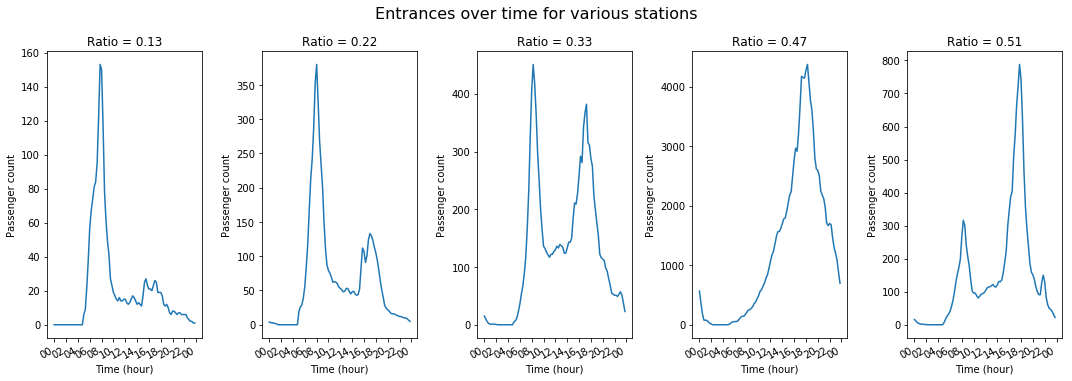

In [16]:
f, ax = plt.subplots(1,5, figsize=(15,5), sharey=False)

for i,limit in enumerate([0.1,0.2,0.3,0.4,0.5]):
    ex_station = ratio_rush_en[(ratio_rush_en > limit) & (ratio_rush_en < limit+0.1)].sample(1).index[0]
    ex = data_en.loc[:,ex_station]
    ratio = ratio_rush_en[ex_station]
    
    ex.plot(ax = ax[i])
    ax[i].xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax[i].set_title(f'Ratio = {ratio:.2f}')
    ax[i].set_xlabel('Time (hour)')
    ax[i].set_ylabel('Passenger count')
    
f.tight_layout()
f.suptitle('Entrances over time for various stations',y=1.05, size=16)
plt.show()

## Spatial analysis

It's hard to imagine what is really going on without some spatial context. In this section we explore some of the spatial patterns that exist in the data, keeping in mind this consistent pattern of day vs. afternoon. This might tell us if these working hubs are in the downtown area like we would expect or if they are scattered about randomly, which would mean that they aren't working hubs at all.

We start by getting an idea of the shape of London.

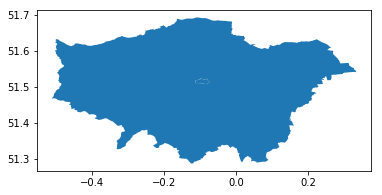

In [17]:
shp_london1 = ox.gdf_from_place('London, England',which_result=2)
shp_london2 = ox.gdf_from_place('London, England',which_result=3)
shp_london = pd.concat([shp_london1, shp_london2])

shp_london.plot();

Now overlay the station locations.

In [18]:
shp_stations = gpd.read_file('../data/london/shapes/stations/stations.shp')
shp_stations.columns = shp_stations.columns.str.lower()
shp_stations.name = shp_stations.name.str.replace('\t','').str.replace('\n','').str.replace(' Station','')

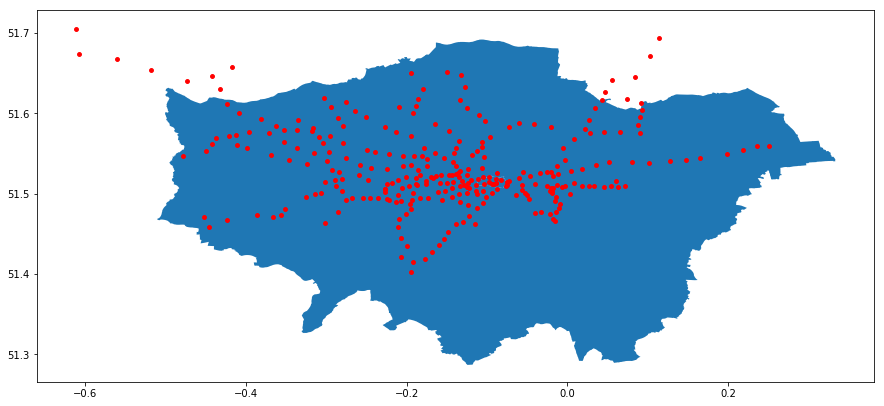

In [19]:
ax = shp_london.plot(figsize=(15,15))
shp_stations.plot(ax=ax, markersize = 15, color='red')

Already we get a sense of how the network covers the city. Now let's see how many people enter/exist at each station. For this we create a bounding cell around each station corresponding to the Voronoi cells. This makes an important assumption: **that people go to the station closest to them**.

TODO: Use Manhattan distance if we have time.

In [20]:
# Get list of stations
stations = data_en.columns.unique()

In [21]:
day_map = {
    '06': 'morning',
    '07': 'morning',
    '08': 'morning',
    '09': 'morning',
    '16': 'afternoon',
    '17': 'afternoon',
    '18': 'afternoon',
    '19': 'afternoon'
}
# TODO use indexer_between_time

In [22]:
# Get the entrances and exists. For this we map times to either morning, afternoon, or None
entrances = data_en.groupby(data_en.index.to_series().dt.strftime('%H').map(day_map, na_action='ignore')).sum()
exits = data_ex.groupby(data_ex.index.to_series().dt.strftime('%H').map(day_map)).sum()

In [23]:
# Assign entrance/exit counts based on station name
shp_stations['entrances_am'] = 0
shp_stations['entrances_pm'] = 0
shp_stations['exits_am'] = 0
shp_stations['exits_pm'] = 0
for station in stations:
    shp_stations.loc[shp_stations.name == station,'entrances_am'] = entrances.loc['morning',station]
    shp_stations.loc[shp_stations.name == station,'entrances_pm'] = entrances.loc['afternoon',station]
    shp_stations.loc[shp_stations.name == station,'exits_am'] = exits.loc['morning',station]
    shp_stations.loc[shp_stations.name == station,'exits_pm'] = exits.loc['afternoon',station]

In [24]:
# Voronoi
x = shp_stations.geometry.x
y = shp_stations.geometry.y
coords = list(zip(x,y))
vor = spatial.Voronoi(coords)

In [25]:
# Convert voronoi cells to shapely polygons
shp_stations['cell'] = None
for i,idx_region in enumerate(vor.point_region):
    region = vor.regions[idx_region]
    cellCoords = [shapely.geometry.Point(vor.vertices[idx_point]) for idx_point in region]
    cell = shapely.geometry.Polygon([[p.x, p.y] for p in cellCoords])
    shp_stations.loc[i,'cell'] = cell

So we have the passenger counts for each station and the cell representation. Let's plot a heatmap of the number of people entering the stations in the morning. We would expect a large amount of people in the fringe of the city and few entrances in the center.

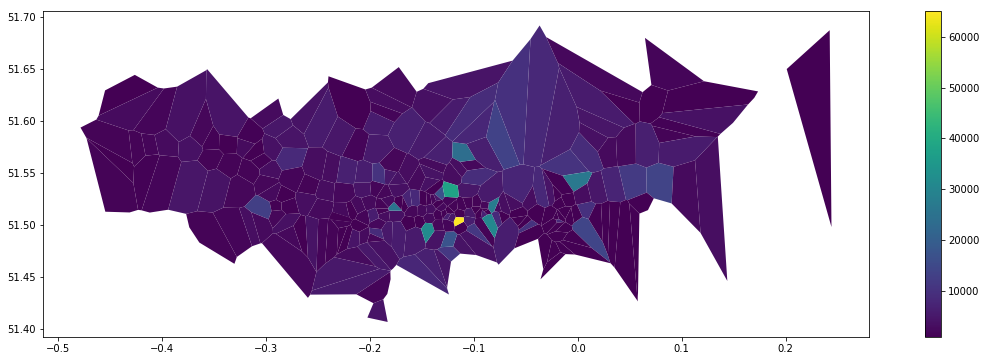

In [26]:
shp_stations = shp_stations.set_geometry('geometry')
box = shapely.geometry.box(shp_stations.geometry.x.min(), shp_stations.geometry.y.min(), shp_stations.geometry.x.max(), shp_stations.geometry.y.max())
shp_stations = shp_stations.set_geometry('cell')
vmin = shp_stations.entrances_am.min()+1000
vmax = shp_stations.entrances_am.max()
ax = shp_stations.loc[shp_stations.within(box)].plot(figsize=(20,6),column='entrances_am',vmin=vmin,vmax=vmax, legend=True)

Surprisingly, the high activity stations are scattered around quite randomly. But we failed to normalize for the overall activity at each station. We need to look at **the ratio** of morning entrances to overall entrances at a given station.

In [27]:
entrances.loc['total'] = data_en.sum()
exits.loc['total'] = data_ex.sum()

In [28]:
shp_stations['entrances_ratio_am'] = 0
shp_stations['entrances_ratio_pm'] = 0
shp_stations['exits_ratio_am'] = 0
shp_stations['exits_ratio_pm'] = 0
for station in stations:
    shp_stations.loc[shp_stations.name == station,'entrances_ratio_am'] = entrances.loc['morning',station]/entrances.loc['total',station]
    shp_stations.loc[shp_stations.name == station,'entrances_ratio_pm'] = entrances.loc['afternoon',station]/entrances.loc['total',station]
    shp_stations.loc[shp_stations.name == station,'exits_ratio_am'] = exits.loc['morning',station]/exits.loc['total',station]
    shp_stations.loc[shp_stations.name == station,'exits_ratio_pm'] = exits.loc['afternoon',station]/exits.loc['total',station]

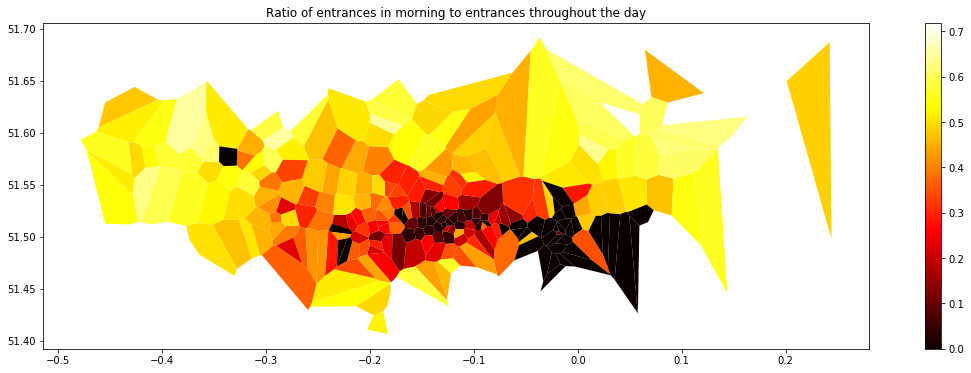

In [29]:
shp_stations = shp_stations.set_geometry('cell')
vmin = shp_stations.entrances_am.min()
vmax = shp_stations.entrances_am.max()
ax = shp_stations.loc[shp_stations.within(box)].plot(figsize=(20,6),column='entrances_ratio_am', cmap='hot', legend=True)
ax.set_title('Ratio of entrances in morning to entrances throughout the day');

And for entrances in the afternoon...

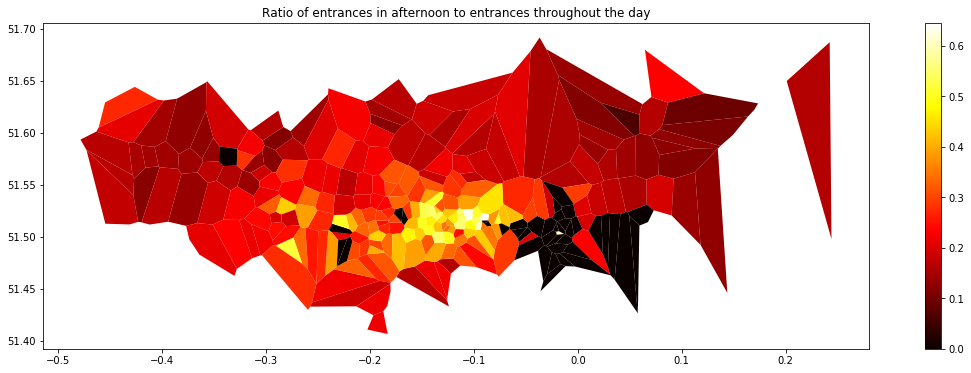

In [30]:
shp_stations = shp_stations.set_geometry('cell')
vmin = shp_stations.entrances_am.min()
vmax = shp_stations.entrances_am.max()
ax = shp_stations.loc[shp_stations.within(box)].plot(figsize=(20,6),column='entrances_ratio_pm', cmap='hot', legend=True)
ax.set_title('Ratio of entrances in afternoon to entrances throughout the day');

And now for exits in the morning...

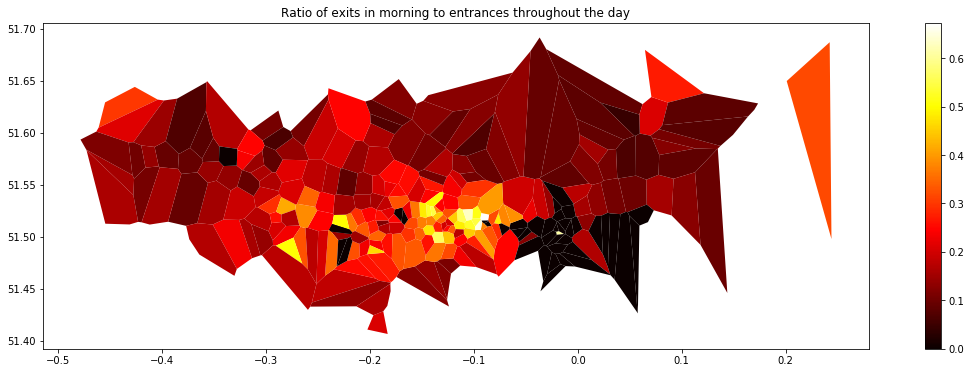

In [31]:
shp_stations = shp_stations.set_geometry('cell')
vmin = shp_stations.entrances_am.min()
vmax = shp_stations.entrances_am.max()
ax = shp_stations.loc[shp_stations.within(box)].plot(figsize=(20,6),column='exits_ratio_am', cmap='hot', legend=True)
ax.set_title('Ratio of exits in morning to entrances throughout the day');

And for exits in the afternoon...

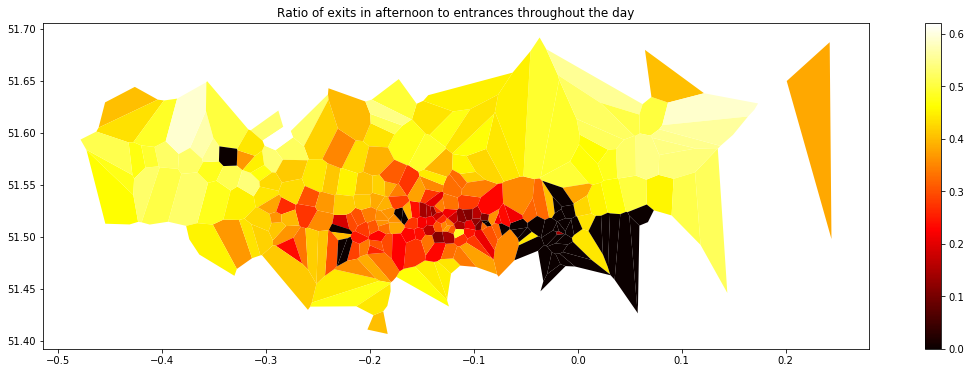

In [32]:
shp_stations = shp_stations.set_geometry('cell')
vmin = shp_stations.entrances_am.min()
vmax = shp_stations.entrances_am.max()
ax = shp_stations.loc[shp_stations.within(box)].plot(figsize=(20,6),column='exits_ratio_pm', cmap='hot', legend=True)
ax.set_title('Ratio of exits in afternoon to entrances throughout the day');

Now we get something much more reasonable. In the daytime, most people are entering in the outskirts of the city. In the afternoon, they enter from downtown. This already confirms one hypothesis we had: the population distribution is significantly different between day and night.

## Population correlation

The goal of this analysis is to see if we can make some conclusions about the population distribution in a city based on its transit data. The epitome of that is to be able to accurately predict how many people live and work at any given part of the city.

Let's see if we can do that. As input we take the entrances and exits into each station (as well as the station locations) and as output we estimate the population in the vicinity of that station. We can then compare the London census population, which is collected on a ward level.

In [33]:
wards = gpd.read_file('/Users/itto/Documents/cities/data/london/shapes/wards/London_Ward.shp')
wards.columns = wards.columns.str.lower()
wards = wards.to_crs(epsg=4326)

In [34]:
ward_pop = pd.read_excel('/Users/itto/Documents/cities/data/london/census/ward_population.xls', sheet_name='2011 Census',skiprows=1,usecols=22)
ward_pop.columns = ward_pop.columns.str.lower()
ward_pop.rename(columns={'ward name': 'name', 'persons: all ages': 'population'}, inplace=True)
ward_pop['adult_population'] = ward_pop[['20 to 24','25 to 29','30 to 34','35 to 39','40 to 44','45 to 49','50 to 54','55 to 59']].sum(axis=1)
ward_pop = ward_pop.loc[ward_pop.name != 'All Wards']

In [35]:
borough_pop = pd.read_csv('/Users/itto/Documents/cities/data/london/census/london-borough-profiles.csv', encoding='latin')
borough_pop.columns = borough_pop.columns.str.lower()

Since we are really only looking at people going to and from work, we are really actually estimating the working age population rather than the total population. Does it matter? Let's see if the two populations are very different.

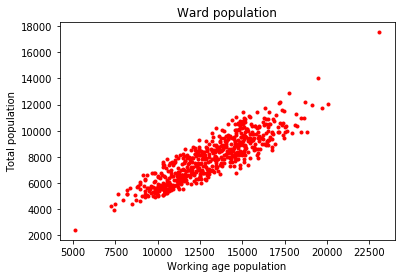

In [36]:
x = ward_pop.population.values
y = ward_pop.adult_population.values
plt.plot(x,y,'r.');
plt.title('Ward population')
plt.xlabel('Working age population')
plt.ylabel('Total population')
plt.show()

The two population sets are highly correlated, which means they are basically interchangeable. But for the sake of completeness, we will use the working age population.

In [37]:
wards = pd.merge(wards,ward_pop[['population','adult_population','borough','name']],on=['borough','name'], how='inner')
wards.rename(columns={'name':'ward'}, inplace=True)

Let's see where our stations are, relative to the ward desginations.

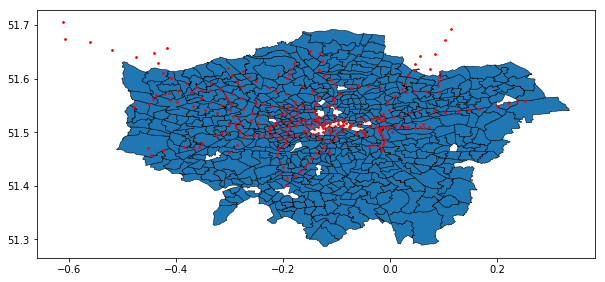

In [38]:
ax = wards.plot(figsize=(10,10), edgecolor='k', lw=0.5)
shp_stations.set_geometry('geometry').plot(ax=ax, color='red', markersize=3);

It's no surprise to see that some wards have higher concentrations of stations than others. We can examine this more closely.

In [39]:
shp_stations.set_geometry('geometry', inplace=True)
# Convert from Point Z to Point
shp_stations.geometry = [shapely.geometry.Point(p) for p in list(zip(shp_stations.geometry.x,shp_stations.geometry.y))]
# Get only the ones inside the box
box = shapely.geometry.box(shp_stations.geometry.x.min(), shp_stations.geometry.y.min(), shp_stations.geometry.x.max(), shp_stations.geometry.y.max())
shp_stations.set_geometry('cell', inplace=True)
shp_stations = shp_stations.loc[shp_stations.within(box)]

In [40]:
joined = gpd.sjoin(shp_stations, wards[['geometry','population']])
joined.rename(columns={'index_right':'ward'},inplace=True)

/Users/itto/miniconda3/envs/cities2/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


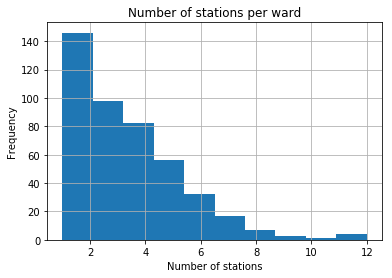

In [41]:
ax = joined.ward.value_counts().hist()
ax.set_title('Number of stations per ward')
ax.set_xlabel('Number of stations')
ax.set_ylabel('Frequency')
plt.show()

Perhaps more interesting is not how many stations we have in each ward, but how many wards does each station get passengers from. That is, if we look at the Voronoi cell of a given station, how many wards does it overlap with?

In [42]:
shp_stations.set_geometry('cell', inplace=True)
overlay = gpd.overlay(shp_stations,wards)

/Users/itto/miniconda3/envs/cities2/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: {'init': 'epsg:4326'} and {'init': 'epsg:4326', 'no_defs': True}
  other.crs))


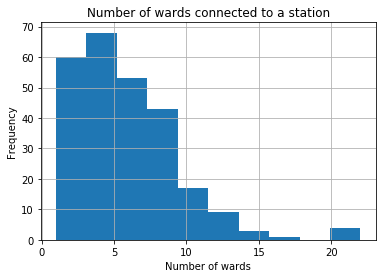

In [43]:
n,bins,patches = plt.hist(overlay.name.value_counts().values,bins=10)
plt.title('Number of wards connected to a station')
plt.xlabel('Number of wards')
plt.ylabel('Frequency')
plt.grid()

On average, each station gets passengers from 6 wards. This means that the spatial resolution of each station, and therefore of our eventual population estimates, is possibly not good enough. Remember, we want to estimate ward population, so a "multi-ward resolution" is too low.

But let's see if this changes when we account for area. A station might overlap with many wards, but maybe most of those overlaps are tiny portions. So let's see what is the largest percentage of the Voronoi cell that is coming from one ward.

In [44]:
overlay_areas = []
for i,group in overlay.groupby('name'):
    overlay_areas.append(group.area.max()/group.area.sum())

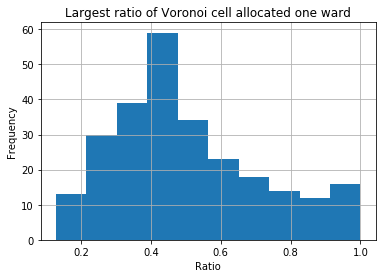

In [45]:
plt.hist(overlay_areas)
plt.title('Largest ratio of Voronoi cell allocated one ward')
plt.xlabel('Ratio')
plt.ylabel('Frequency')
plt.grid()

We see now that most stations have 40% or more of their Voronoi cell overlapping with one ward. This gives us some confidence that if 1000 passengers exit a station at night, then most likely they are residents of one ward.

In any case, we will assume that the percentage of passengers from each ward is proportional to the portion of the area of the Voronoi cell overlapping with that ward. One way to compare the estimated to actual population is to plot them as a scatter plot. We should see some correlation between the two.

In [46]:
wards['entrances'] = 0
for i,group in overlay.groupby('name'):
    wards.loc[wards.gss_code.isin(group.gss_code.unique()), 'entrances'] += (group.area/group.area.sum()*group.entrances_am).values

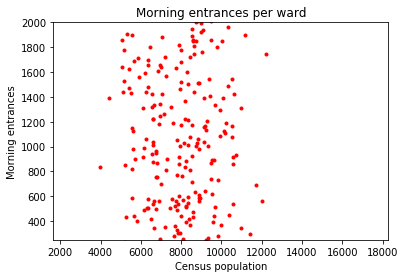

In [47]:
plot_data = wards
x = plot_data.adult_population.values
y = plot_data.entrances.values
plt.plot(x,y,'r.')
plt.ylim((250,2000))
plt.ylabel('Morning entrances')
plt.xlabel('Census population')
plt.title('Morning entrances per ward')
plt.show()

There is essentially no correlation between the census population and the number of people entering a station in the morning. For due diligence, we should also look at the people exiting in the afternoon.

In [48]:
wards['exits'] = 0
for i,group in overlay.groupby('name'):
    wards.loc[wards.gss_code.isin(group.gss_code.unique()), 'exits'] += (group.area/group.area.sum()*group.exits_pm).values

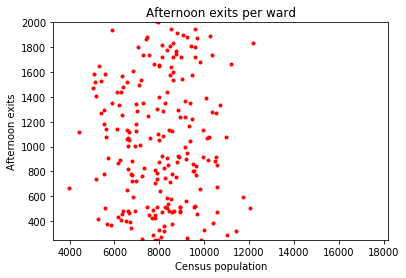

In [49]:
plot_data = wards[wards.exits > 0] # Don't count non-zero values
x = plot_data.adult_population.values
y = plot_data.exits.values
plt.plot(x,y,'r.')
plt.ylim((250,2000))
plt.ylabel('Afternoon exits')
plt.xlabel('Census population')
plt.title('Afternoon exits per ward')
plt.show()

Let's try going back a step. Instead of accounting for all the wards that each Voronoi cell overlaps with, let's just estimate population based on the ward in which the station is located. I.e. the population of a ward is the sum of the passanger counts for the stations inside the ward. There's no real motivation for this, other than to simplify things.

In [50]:
shp_stations.set_geometry('geometry', inplace=True)
# Buffer the points by a miniscule amount so they become dummy polygons
shp_stations['point_buffered'] = shp_stations.buffer(0.000001)
shp_stations.set_geometry('point_buffered', inplace=True)
overlay_simple = gpd.overlay(shp_stations, wards)

/Users/itto/miniconda3/envs/cities2/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: {'init': 'epsg:4326'} and {'init': 'epsg:4326', 'no_defs': True}
  other.crs))


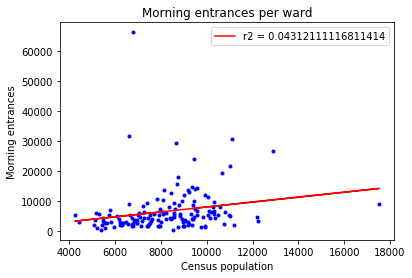

In [51]:
plot_data = overlay_simple[overlay_simple.entrances_am > 0]
x = plot_data.groupby(['ward','borough']).adult_population.mean().values
y = plot_data.groupby(['ward','borough']).entrances_am.sum().values
lin = stats.linregress(x,y)
plt.plot(x,y,'b.')
plt.plot(x,x*lin[0]+lin[1],'r', label=f'r2 = {lin[2]**2}')
plt.ylabel('Morning entrances')
plt.xlabel('Census population')
plt.title('Morning entrances per ward')
plt.legend()
plt.show()

Once again, there's no real correlation. Could this be an issue with resolution? Throughout this analysis, we assume that passengers do not travel significant distances using means other than train (bus, car, bike, etc.) prior to and following their train trip. But the wards might be so small that this assumption might not hold. That is, the wards might be small enough such that if a passenger makes a bus trip, for example, prior to his train trip, he could easily be crossing wards, and therefore we would count him as a resident of ward A when really he is a resident fo ward B who took a bus to a station in ward A.

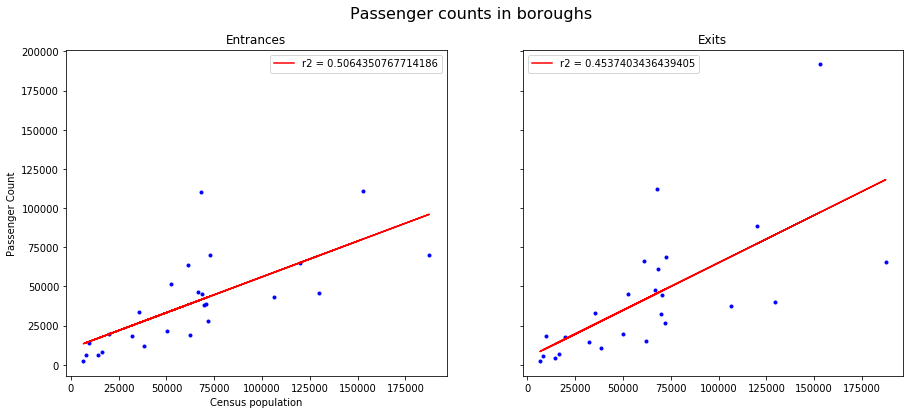

In [52]:
f,ax = plt.subplots(1,2, figsize=(15,6), sharey=True)

plot_data = overlay_simple[overlay_simple.entrances_am > 0]
x = plot_data.groupby(['borough']).adult_population.sum().values
y = plot_data.groupby(['borough']).entrances_am.sum().values
lin = stats.linregress(x,y)
ax[0].plot(x,y,'b.')
ax[0].plot(x,x*lin[0]+lin[1],'r', label=f'r2 = {lin[2]**2}')
ax[0].set_title('Entrances')
ax[0].set_ylabel('Passenger Count')
ax[0].set_xlabel('Census population')
ax[0].legend()

plot_data = overlay_simple[overlay_simple.exits_pm > 0]
x = plot_data.groupby(['borough']).adult_population.sum().values
y = plot_data.groupby(['borough']).exits_pm.sum().values
lin = stats.linregress(x,y)
ax[1].plot(x,y,'b.')
ax[1].plot(x,x*lin[0]+lin[1],'r', label=f'r2 = {lin[2]**2}')
ax[1].set_title('Exits')
ax[1].legend()

f.suptitle('Passenger counts in boroughs', size=16)
plt.show()

It's still not a great fit, but at least we are getting somwhere. Let's go back to what we did before, where we allocated passenger counts to each ward based on the percentage overlap of the Voronoi cell. Except this time we look at the overlap with boroughs.

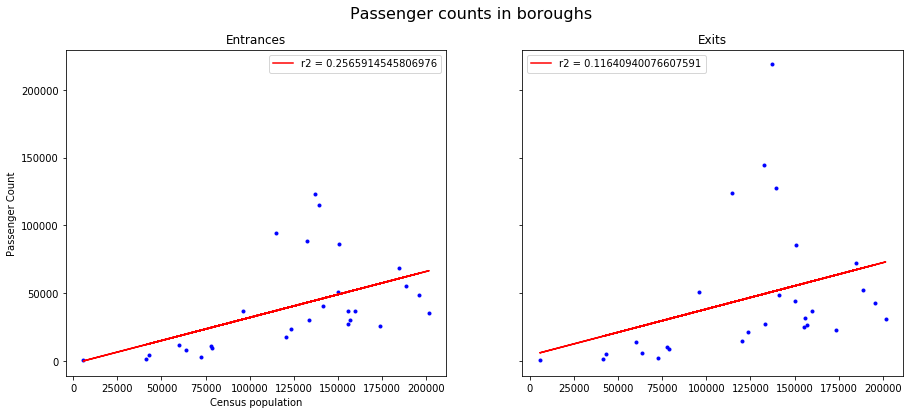

In [53]:
f,ax = plt.subplots(1,2, figsize=(15,6), sharey=True)

plot_data = wards[wards.entrances > 0]
x = plot_data.groupby(['borough']).adult_population.sum().values
y = plot_data.groupby(['borough']).entrances.sum().values
lin = stats.linregress(x,y)
ax[0].plot(x,y,'b.')
ax[0].plot(x,x*lin[0]+lin[1],'r', label=f'r2 = {lin[2]**2}')
ax[0].set_title('Entrances')
ax[0].set_ylabel('Passenger Count')
ax[0].set_xlabel('Census population')
ax[0].legend()

plot_data = wards[wards.exits > 0]
x = plot_data.groupby(['borough']).adult_population.sum().values
y = plot_data.groupby(['borough']).exits.sum().values
lin = stats.linregress(x,y)
ax[1].plot(x,y,'b.')
ax[1].plot(x,x*lin[0]+lin[1],'r', label=f'r2 = {lin[2]**2}')
ax[1].set_title('Exits')
ax[1].legend()

f.suptitle('Passenger counts in boroughs', size=16)
plt.show()

The fit is much worse, notably due to a few high outliers. Why is the fit worse than before? Shouldn't the accuracy increase when we account for overlaps? As a motivation, let's see the fit when we discard these high outliers.

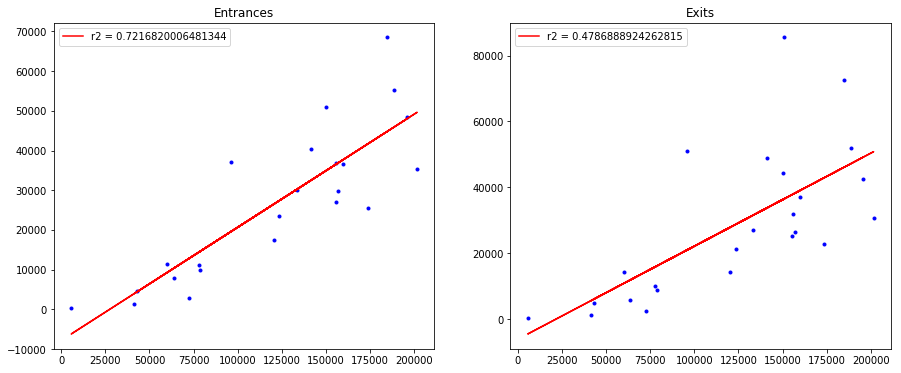

In [54]:
f,ax = plt.subplots(1,2, figsize=(15,6))

plot_data = wards[wards.entrances > 0]
x = plot_data.groupby(['borough']).adult_population.sum().values
y = plot_data.groupby(['borough']).entrances.sum().values
x = x[y<80000]
y = y[y<80000]
lin = stats.linregress(x,y)
ax[0].plot(x,y,'b.')
ax[0].plot(x,x*lin[0]+lin[1],'r', label=f'r2 = {lin[2]**2}')
ax[0].set_title('Entrances')
ax[0].legend()

plot_data = wards[wards.exits > 0]
x = plot_data.groupby(['borough']).adult_population.sum().values
y = plot_data.groupby(['borough']).exits.sum().values
x = x[y < 100000]
y = y[y<100000]
lin = stats.linregress(x,y)
ax[1].plot(x,y,'b.')
ax[1].plot(x,x*lin[0]+lin[1],'r', label=f'r2 = {lin[2]**2}')
ax[1].set_title('Exits')
ax[1].legend()

# Extra

Extra analys. Ignore for now.

## Oyster data

We also have the Oyster card dataset. It gives us O-D pairs and is a lot more detailed in general. We should do a preliminary check to see if we get the same entrance/exit patterns. To do this we plot them side by side.

In [55]:
stations = data_plot_en.columns.unique()

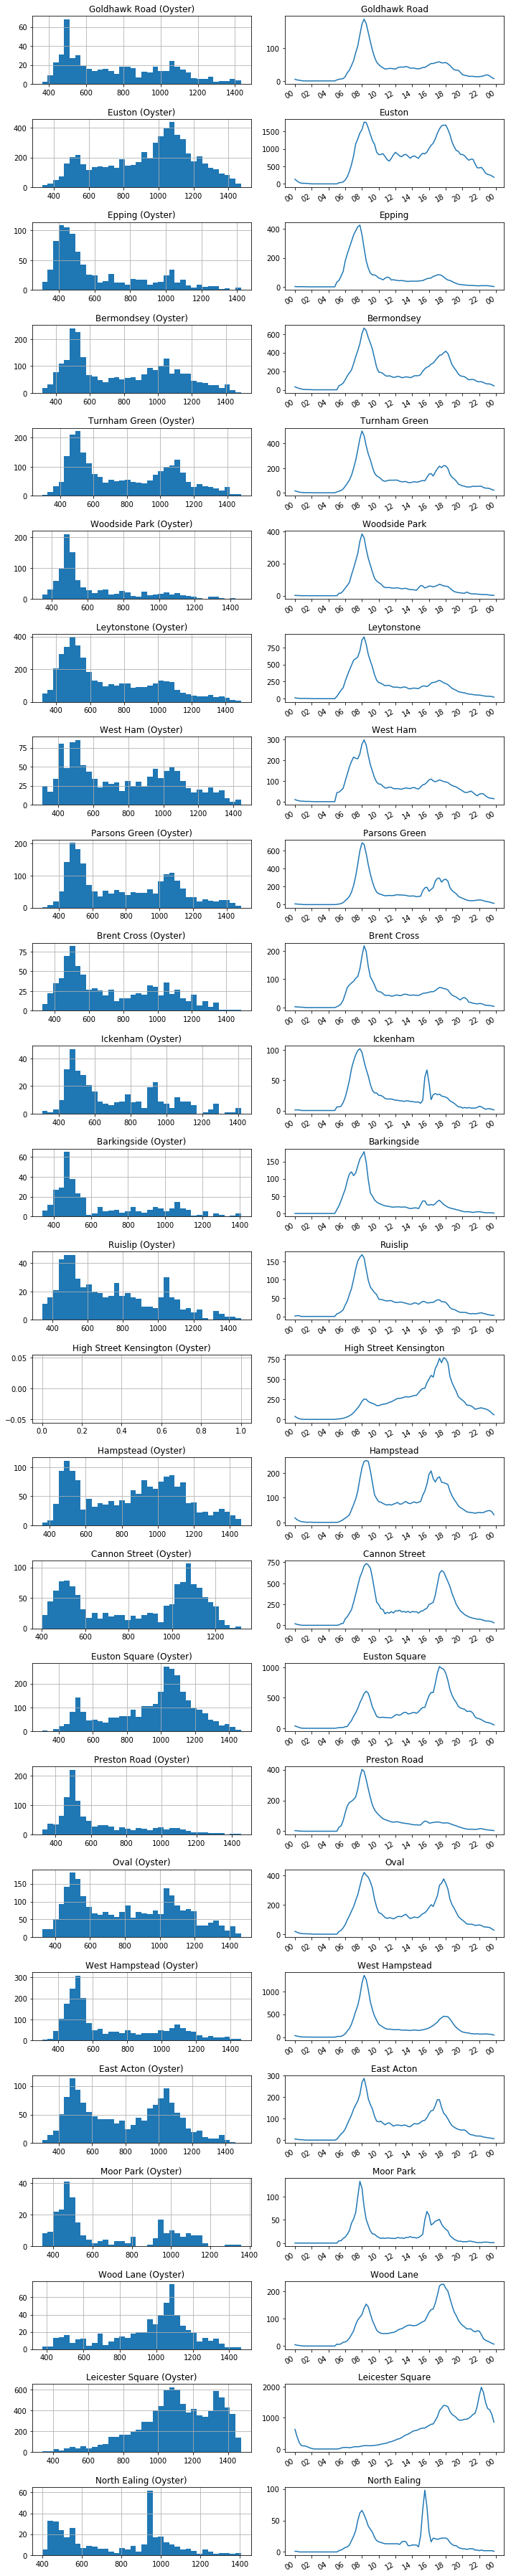

In [56]:
f, axes = plt.subplots(MONTAGE_SIZE*MONTAGE_SIZE,2,figsize=(10,50), sharey=False, sharex=False)
axes = axes.flatten().tolist()
for station in stations:
        plot_data = oyster_data.loc[oyster_data.StartStn == station,'EntTime']
        ax = axes.pop(0)
        plot_data.hist(ax=ax, bins=36)
        ax.set_title(station + ' (Oyster)')
        ax = axes.pop(0)
        data_plot_en.loc[:,station].plot(ax=ax, color='C0')
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
        ax.set_title(station)
f.tight_layout()
plt.show()

By inspection we can see that the Oyster data, which is limited to 5% of the riders, is more noisy but that it still follows the same distribution of the overall ridership. So it's reasonable to assume that the O-D pairs in the Oyster data represent a good sample of the trips of all riders. This means we can reasonably comfortably use the Oyster data, knowing that it's a good representation of the overall dynamics.

## O-D Matrix

Convert to an origin-destination matrix

In [57]:
# Get all stations
stations = np.concatenate([oyster_data.StartStn.str.lower().unique(),oyster_data.EndStation.str.lower().unique()])
# Convert to df so we can remove duplicates
stations = pd.DataFrame({'name': stations}).name.unique()

In [58]:
od = pd.DataFrame(index=stations, columns=stations)
# Alphabetical
od = od.sort_index()
od.columns = od.columns.sort_values()
od.fillna(0, inplace=True)

In [ ]:
%%time
for (i,j),group in oyster_data.groupby(['StartStn','EndStation']):
    od.at[i.lower(),j.lower()] = group.shape[0]
# Check validity
assert(oyster_data.shape[0]==od.sum().sum())

We have our OD matrix. Let's examine some properties so we understand what's going on here:

In [60]:
print('Total number of trips: ',od.sum().sum())
print('Number of loop trips: ',np.diag(od).sum())
print('Number of unfinished trips: ',od.loc[:,'unfinished'].sum())

Total number of trips:  504607
Number of loop trips:  3159
Number of unfinished trips:  24091


Loop trips (same destination as origin) and unfinished trips are both not really relevant to us. So about 5% of the data is immediately disqualifiable. This isn't great, but it still leaves us with 750,000+ data points.

In [61]:
np.fill_diagonal(od.values,0)

In [62]:
od.drop('unfinished', axis=0, inplace=True)
od.drop('unfinished', axis=1, inplace=True)

In [63]:
od.sum().sum()

477357

Let's see how symmetric the matrix is. We would expect the matrix to be symmetric. That is, we expect people to go back the same way they came.

In [64]:
# TODO Filter weekends

## Appendix

Staion entrances, and corresponding location on map.

In [ ]:
plot_stations = shp_stations.loc[shp_stations.within(box)].copy()
f, axes = plt.subplots(MONTAGE_SIZE**2,2,figsize=(10,2*MONTAGE_SIZE**2), sharey=False, sharex=False)
for i in range(MONTAGE_SIZE**2)[:]:
    ax = axes.flatten()[i*2]
    data_plot_en.iloc[:,i].plot(ax=ax, lw=4)
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax.set_title(data_plot_en.columns[i])
    ax = axes.flatten()[i*2+1]
    # Set all highlights to 0
    plot_stations['highlight'] = 0
    # Highlight the current station
    plot_stations.loc[plot_stations.name == data_plot_en.columns[i],'highlight'] = 1
    plot_stations.plot(column = 'highlight',ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
# f.suptitle('Entrances over time',y=1.05)
plt.tight_layout()
plt.show()

Boxplots

In [ ]:
f,ax = plt.subplots(1,1,figsize=(18,8))
data_en.groupby(data_en.index.hour).sum().T.boxplot(ax=ax, showfliers=False, rot=0, grid=False)
ax.set_xlabel('Time (hour)')
ax.set_ylabel('Passenger count')
ax.set_title('Distribution of entrances into stations')
plt.show()

In [ ]:
f,ax = plt.subplots(1,1,figsize=(18,8))
data_ex.groupby(data_ex.index.hour).sum().T.boxplot(ax=ax, showfliers=False, rot=0, grid=False)
ax.set_xlabel('Time (hour)')
ax.set_ylabel('Passenger count')
ax.set_title('Distribution of exits from stations')
plt.show()

Once again, we see that most stations exhibit a residential behaviour, but that there are a few "outlier" stations which have a work-hub pattern. We can look at the balance between these types of patterns by examining the ratio of rush hour entrances compared to overall entrances.

Let's see a heatmap showing our estimated population based on afternoon exits.

In [ ]:
f,ax = plt.subplots(1,2, figsize = (15,8))
plot_data = wards[wards.entrances<8000]
# Set vmax to something lower, so we have more dynamic range
vmax = plot_data.entrances.max()
plot_data.plot(ax = ax[0], column='entrances', cmap='hot');
ax[0].set_title('Number of morning entrances per ward');
plot_data.plot(ax = ax[1], column='adult_population', cmap='hot');
ax[1].set_title('Actual ward population based on census');

In [ ]:
f,ax = plt.subplots(1,2, figsize = (15,8))
wards.plot(ax = ax[0], column='exits', cmap='hot', edgecolor='k', vmin=wards[wards.entrances > 0].entrances.min());
ax[0].set_title('Number of afternoon exits per ward');
wards.plot(ax = ax[1], column='adult_population', cmap='hot', edgecolor='k');
ax[1].set_title('Actual ward population based on census');